<a href="https://colab.research.google.com/github/nmatsumoto-lgtm/study-KIKAGAKU/blob/main/%E4%B8%8D%E5%8B%95%E7%94%A3%E4%BE%A1%E6%A0%BC%E4%BA%88%E6%B8%AC%E3%82%A2%E3%83%97%E3%83%AA_Ver_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install lightgbm==4.5.0 optuna==3.6.1 joblib pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 36.3 MB/s eta 0:00:00


In [2]:
from __future__ import annotations
import json
from pathlib import Path
from dataclasses import dataclass


import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error
from joblib import dump

In [3]:
SEED = 0
np.random.seed(SEED)

In [4]:
IN = Path("data/interim/train_tabular.csv")
OUT_DIR = Path("models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# ============================
# 1) データ読み込み & 追加特徴量
# ============================

def _oof_target_median(df: pd.DataFrame, key: str, y: np.ndarray, n_splits: int = 5) -> np.ndarray:
    """キー列ごとの OOF 中央値エンコーディング（リーク防止）。
    戻り値は各行に対応する OOF 推定値（学習折ごとに学習外の中央値を使う）。
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        med = (
            pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
            .groupby(key)["y"].median()
        )
        oof[va_idx] = df.iloc[va_idx][key].map(med).fillna(med.median()).values
    return oof


def build_table_and_features() -> tuple[pd.DataFrame, list[str], list[str], list[str], list[int]]:
    df = pd.read_csv(IN)

    # ===== 対数ターゲット =====
    y = df["price_yen"].astype(float).values
    y_log = np.log1p(y)

    # ===== 追加特徴量 =====
    df["access_score"] = 1.0 / (1.0 + df["walk_min"].astype(float))
    df["sqrt_area"] = np.sqrt(np.clip(df["area_sqm"].astype(float), 0, None))
    df["log_area"] = np.log1p(np.clip(df["area_sqm"].astype(float), 0, None))
    df["age_sqrt"] = np.sqrt(np.clip(df["築年数"].astype(float), 0, None))
    df["area_x_access"] = df["area_sqm"].astype(float) * df["access_score"].astype(float)

    # 頻度特徴量（全体集計）
    station_cnt = df["station"].value_counts()
    layout_cnt  = df["layout"].value_counts()
    df["station_count"] = df["station"].map(station_cnt).fillna(0).astype(int)
    df["layout_count"]  = df["layout"].map(layout_cnt).fillna(0).astype(int)

    # OOF 目標エンコード（中央値）※対数ターゲットで作る
    df["station_oof_median_log"] = _oof_target_median(df, "station", y_log)
    df["layout_oof_median_log"]  = _oof_target_median(df, "layout",  y_log)

    # --- 推論時に必要な「学習時の統計」を作っておく（新規データに同じ変換を適用するため）
    station_med_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].median().to_dict()
    )
    layout_med_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].median().to_dict()
    )
    global_station_med = float(np.median(list(station_med_map.values()))) if len(station_med_map) else float(np.median(y_log))
    global_layout_med  = float(np.median(list(layout_med_map.values())))  if len(layout_med_map)  else float(np.median(y_log))

    # カテゴリ列
    feat_cat = ["station", "layout"]

    # 数値列（順序固定）
    feat_num_base = ["walk_min", "築年数", "area_sqm"]
    feat_num_extra = [
        "access_score", "sqrt_area", "log_area", "age_sqrt",
        "area_x_access", "station_count", "layout_count",
        "station_oof_median_log", "layout_oof_median_log",
    ]
    feat_num_all = feat_num_base + feat_num_extra

    # 単調性制約（[cat..., num...] の順で並ぶことに注意）
    n_cat = len(feat_cat)
    mono_num = [-1, -1, +1] + [0] * (len(feat_num_all) - 3)
    monotone_constraints = [0] * n_cat + mono_num

    # ====== エンコードして学習用テーブルを構成 ======
    oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat = oe.fit_transform(df[feat_cat].fillna("NA")).astype("int32")
    X_num = df[feat_num_all].astype(float).values
    X = np.hstack([X_cat, X_num])

    cat_cols = [f"cat__{c}" for c in feat_cat]
    num_cols = feat_num_all.copy()
    X_df = pd.DataFrame(X, columns=cat_cols + num_cols)
    categorical_feature = cat_cols

    meta = {
        "feat_cat": feat_cat,
        "feat_num": num_cols,
        "categorical_feature": categorical_feature,
        "monotone_constraints": monotone_constraints,
    }

    # ★ 推論用マップ（統計 + 列順）をまとめて返す
    infer_maps = {
        "station_count_map": station_cnt.to_dict(),
        "layout_count_map": layout_cnt.to_dict(),
        "station_median_log_map": station_med_map,
        "layout_median_log_map": layout_med_map,
        "global_station_median_log": global_station_med,
        "global_layout_median_log": global_layout_med,
        "feat_cat": feat_cat,
        "feat_num": num_cols,
    }

    # ★ 返り値に infer_maps を追加（＝合計7つ）
    return X_df, y_log, categorical_feature, monotone_constraints, meta, oe, infer_maps


In [6]:
# ============================
# 2) Optuna でハイパラ探索
# ============================

def tune_with_optuna(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    n_trials: int = 80,
) -> tuple[dict, int, float]:
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    def objective(trial: optuna.Trial) -> float:
        params = {
            "objective": "rmse",  # 対数価格の RMSE → RMSLE 等価
            "metric": "rmse",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 5.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "verbosity": -1,
            "seed": SEED,
            "monotone_constraints": monotone_constraints,
        }
        rmsles = []
        best_iters = []
        for tr_idx, va_idx in kf.split(X_df):
            X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            y_tr, y_va = y_log[tr_idx], y_log[va_idx]
            dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_feature, free_raw_data=True)
            dva = lgb.Dataset(X_va, label=y_va, categorical_feature=categorical_feature, free_raw_data=True)

            model = lgb.train(
                params,
                dtr,
                valid_sets=[dva],
                num_boost_round=4000,
                callbacks=[lgb.early_stopping(200, verbose=False)],
            )
            pred_log = model.predict(X_va, num_iteration=model.best_iteration)
            # y_log の RMSE = RMSLE（expm1 に戻した価格に対する）
            rmsle = float(np.sqrt(mean_squared_log_error(np.expm1(y_va), np.expm1(pred_log))))
            rmsles.append(rmsle)
            best_iters.append(model.best_iteration)
        trial.set_user_attr("best_iters", best_iters)
        return float(np.mean(rmsles))

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    # CV で選ばれた best_iteration を平均化
    best_iters_list = study.best_trial.user_attrs.get("best_iters", [1000])
    best_round = int(np.clip(np.mean(best_iters_list), 100, 4000))
    best_score = study.best_value
    return best_params, best_round, best_score

In [7]:
# ============================
# 3) 最終学習（ポイント & 分位点）
# ============================

def train_final_models(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    best_params: dict,
    best_round: int,
):
    base_params = dict(best_params)
    base_params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        # ★ ポイントモデルでは単調性制約を使う
        "monotone_constraints": monotone_constraints,
    })

    # 生データを解放しない（categorical_feature を後で使えるように）
    dtrain = lgb.Dataset(
        X_df,
        label=y_log,
        categorical_feature=categorical_feature,
        free_raw_data=False
    )

    # ---- ポイント（対数価格）----
    model_point = lgb.train(base_params, dtrain, num_boost_round=best_round)

    # ---- 分位点（q10/q90）----
    models_q = {}
    for alpha, tag in [(0.1, "q10"), (0.9, "q90")]:
        q_params = dict(best_params)
        q_params.update({
            "objective": "quantile",
            "alpha": alpha,
            "metric": "quantile",
            "verbosity": -1,
            "seed": SEED,
            # ★ ここが重要：quantile では単調性制約を外す
            # "monotone_constraints": monotone_constraints,  # ←入れない
        })
        models_q[tag] = lgb.train(q_params, dtrain, num_boost_round=best_round)

    return model_point, models_q


In [8]:
# ===== 入力CSV→中間CSVの自動生成（なければ作る） =====
from pathlib import Path
import pandas as pd, numpy as np, re
from datetime import datetime

RAW_CSV = Path("/content/Tokyo_Chuo Ward_20242_20251.csv")
IN = Path("data/interim/train_tabular.csv")
ST_OUT = Path("data/interim/stations.csv")
IN.parent.mkdir(parents=True, exist_ok=True)

def _read_chuo_and_save(raw_csv: Path, out_csv: Path, stations_csv: Path):
    # エンコーディングを順に試す（Excel想定）
    last_err = None
    for enc in ("cp932", "utf-8-sig", "utf-8", "utf-16", "utf-16le", "utf-16be"):
        try:
            raw = pd.read_csv(raw_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            raw = None
    if raw is None:
        raise last_err

    def _to_year(x):
        if pd.isna(x): return np.nan
        m = re.search(r"(\d{4})年", str(x))
        return int(m.group(1)) if m else np.nan

    df = raw[["最寄駅：名称","最寄駅：距離（分）","間取り","面積（㎡）","建築年","取引価格（総額）"]].copy()

    build_year = df["建築年"].apply(_to_year)
    current_year = datetime.now().year
    df["築年数"] = (current_year - build_year).clip(lower=0)

    for col in ["最寄駅：距離（分）","面積（㎡）","築年数"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(df[col].median())

    def _normalize_layout(s):
        if not isinstance(s,str): return "その他"
        s = s.upper().replace("Ｌ","L").replace("Ｄ","D").replace("Ｋ","K").replace("Ｒ","R")
        m = re.search(r"(\d+)(LDK|DK|K|R)", s)
        return m.group(0) if m else "その他"

    train = df.rename(columns={
        "最寄駅：名称":"station",
        "最寄駅：距離（分）":"walk_min",
        "面積（㎡）":"area_sqm",
        "取引価格（総額）":"price_yen",
    })[["station","walk_min","築年数","area_sqm","price_yen"]].copy()
    train["layout"] = df["間取り"].astype(str).apply(_normalize_layout)

    # 保存（StreamlitもこのCSVを読む）
    train.to_csv(out_csv, index=False)

    # 駅リスト保存（utf-8-sig）
    s = (raw["最寄駅：名称"].astype(str)
           .replace({"nan":np.nan,"None":np.nan,"":np.nan})
           .dropna()
           .str.normalize("NFKC")
           .str.replace("（","(",regex=False).str.replace("）",")",regex=False)
           .str.replace("　"," ",regex=False).str.strip()
           .str.replace(r"\s+"," ",regex=True))
    pd.Series(sorted(s.unique())).to_csv(stations_csv, index=False, header=False, encoding="utf-8-sig")

# まだ中間CSVがない場合は作る
if not IN.exists():
    if not RAW_CSV.exists():
        raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
    _read_chuo_and_save(RAW_CSV, IN, ST_OUT)

In [9]:
# ============================
# 4) 実行
# ============================

if __name__ == "__main__":
    assert IN.exists(), f"Not found: {IN}"

    # ★ infer_maps まで受け取る（関数が infer_maps を返す実装になっている前提）
    X_df, y_log, cat_cols, mono_cons, meta, oe, infer_maps = build_table_and_features()

    print(f"Train rows: {len(X_df):,}, cols: {X_df.shape[1]} (cats={len(cat_cols)})")

    best_params, best_round, best_score = tune_with_optuna(
        X_df, y_log, cat_cols, mono_cons, n_trials=80
    )
    print("[OPTUNA] best RMSLE:", round(best_score, 4))
    print("[OPTUNA] best params:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print("[OPTUNA] best_round:", best_round)

    model_point, models_q = train_final_models(
        X_df, y_log, cat_cols, mono_cons, best_params, best_round
    )

    # ===== 保存 =====
    # 予測時に使うメタ情報（列順や制約）とエンコーダを一緒に保存しておく
    dump({
        "model": model_point,
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
    }, OUT_DIR / "lgbm_optuna_point.pkl")

    dump({
        "model": models_q["q10"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.1,
    }, OUT_DIR / "lgbm_optuna_q10.pkl")

    dump({
        "model": models_q["q90"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.9,
    }, OUT_DIR / "lgbm_optuna_q90.pkl")

    with open(OUT_DIR / "feature_config.json", "w", encoding="utf-8") as f:
        json.dump({
            "feat_cat": meta["feat_cat"],
            "feat_num": meta["feat_num"],
            "categorical_feature": meta["categorical_feature"],
            "monotone_constraints": meta["monotone_constraints"],
            "notes": "y is log1p(price_yen). During inference, apply expm1 to predictions.",
        }, f, ensure_ascii=False, indent=2)

    # ★ 推論用マップも保存（カッコを閉じるのを忘れない）
    with open(OUT_DIR / "infer_maps.json", "w", encoding="utf-8") as f:
        json.dump(infer_maps, f, ensure_ascii=False, indent=2)

    print("Saved models →", OUT_DIR)


[I 2025-09-05 13:23:09,592] A new study created in memory with name: no-name-84d43f85-84d5-4cc5-94f6-ba20de0a9f81


Train rows: 1,784, cols: 14 (cats=2)


[I 2025-09-05 13:23:12,857] Trial 0 finished with value: 0.2028260417716004 and parameters: {'learning_rate': 0.011623664237606506, 'num_leaves': 47, 'min_data_in_leaf': 16, 'feature_fraction': 0.9245342170478121, 'bagging_fraction': 0.7869498242562027, 'bagging_freq': 1, 'min_gain_to_split': 1.6778120532479242, 'lambda_l1': 2.2300059771155958e-08, 'lambda_l2': 0.0009341111066543173}. Best is trial 0 with value: 0.2028260417716004.
[I 2025-09-05 13:23:14,813] Trial 1 finished with value: 0.2370376931980566 and parameters: {'learning_rate': 0.07649324220110656, 'num_leaves': 98, 'min_data_in_leaf': 97, 'feature_fraction': 0.642539282121936, 'bagging_fraction': 0.6993736190585199, 'bagging_freq': 6, 'min_gain_to_split': 4.1274393571171055, 'lambda_l1': 0.015987678970547294, 'lambda_l2': 0.0001181225241459408}. Best is trial 0 with value: 0.2028260417716004.
[I 2025-09-05 13:23:17,278] Trial 2 finished with value: 0.21968713855708658 and parameters: {'learning_rate': 0.02574544390332385, 

[OPTUNA] best RMSLE: 0.1735
[OPTUNA] best params:
  learning_rate: 0.058141998799072656
  num_leaves: 231
  min_data_in_leaf: 29
  feature_fraction: 0.8105357500349619
  bagging_fraction: 0.7843995115541147
  bagging_freq: 6
  min_gain_to_split: 0.007188940618505075
  lambda_l1: 0.0024003036346974187
  lambda_l2: 0.20292813042246605
[OPTUNA] best_round: 423
Saved models → models


                   feature   importance
4                 area_sqm  3483.583063
6                sqrt_area  1237.224010
3                      築年数   478.523557
8                 age_sqrt   285.438011
13   layout_oof_median_log   263.109512
9            area_x_access   163.688200
7                 log_area   129.406952
12  station_oof_median_log    44.831072
10           station_count    42.054285
0             cat__station    37.315779
11            layout_count    32.063039
1              cat__layout    28.335888
5             access_score    27.485378
2                 walk_min    24.792471


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


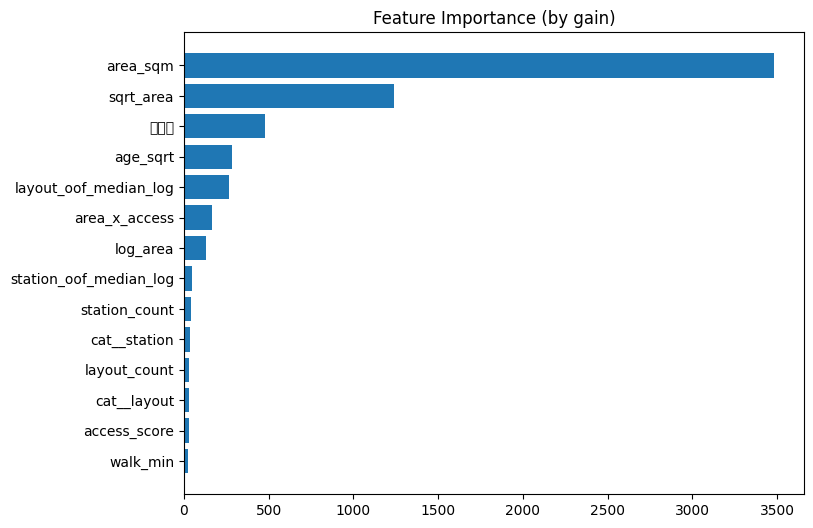

In [10]:
import matplotlib.pyplot as plt

# 重要度を取得
importance = model_point.feature_importance(importance_type="gain")
feature_names = model_point.feature_name()

# DataFrame化
import pandas as pd
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

print(fi)

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (by gain)")
plt.show()